## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
## load universe_factors
universe = pd.read_csv('factor_data/all_119_zscore.csv')
universe['date'] = pd.to_datetime(universe['trade_date'],format='%Y%m%d')
universe.set_index(['date'],inplace=True)
universe = universe.loc[universe['trade_date']>20190401]
universe = universe.fillna(0.)
universe.tail()

,ts_code,trade_date,turnover_rate,pe,pb,ps,dv_ratio,total_share,free_share,total_mv,...,alpha_083,alpha_101,alpha_103,alpha_122,section1,section2,alpha_149,ind_val,alpha_kama3,alpha_fundamental
date,,,,,,,,,,,,,,,,,,,,,
2023-04-27,688363.SH,20230427,2.4352,49.3217,7.1823,7.5304,0.0,48152.1852,16358.8566,4.788735e+06,...,0.311811,-1.000000,-0.675767,0.386960,0.0,0.0,0.674229,1,-1.000000,-0.094367
2023-04-27,688579.SH,20230427,5.6325,99.8208,4.7113,13.6154,0.0,40001.0000,24707.5540,6.180154e+05,...,0.374593,0.893343,-0.955454,-0.347171,0.0,0.0,-0.488621,0,0.595495,-0.988528
2023-04-27,688589.SH,20230427,3.7899,58.1765,5.2034,8.6687,0.0,10019.4770,5667.1437,4.367490e+05,...,-0.268983,-1.000000,-1.000000,-0.208012,0.0,0.0,0.109748,0,-0.286370,-0.909127
2023-04-27,688655.SH,20230427,2.2024,34.6815,2.3481,3.6148,0.0,13339.0000,5493.9800,1.607350e+05,...,0.148819,0.895419,0.370277,0.470410,0.0,0.0,0.227516,0,0.747141,-0.304981
2023-04-27,688799.SH,20230427,3.4769,24.3835,2.4588,3.4187,0.0,9380.0000,4211.3000,3.919902e+05,...,-0.029086,0.999428,-0.886591,-0.162185,0.0,0.0,0.105318,1,-0.191757,0.133118


In [3]:
universe['alpha_009'] = -universe['alpha_009']
universe['alpha_kama2'] = -universe['alpha_kama2']

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [4]:
all_factors = universe.copy(deep=True)
universe.industry.unique()

array(['医药商业', '化学制药', '软件服务', 'IT设备', '互联网', '中成药', '化工原料', '生物制药',
       '医疗保健', '元器件', '半导体', '纺织', '机械基件'], dtype=object)

In [5]:
# sector_dict = {'软件服务':1, '医疗保健':2, '化学制药':3, '中成药':4, 'IT设备':5, '互联网':6, '生物制药':7, '化工原料':8,
#        '医药商业':9, '元器件':10, '半导体':11}
sector_dict = {1:1, 0:0}
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['ind_val']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,pe,pb,ps,dv_ratio,total_share,free_share,total_mv,...,alpha_103,alpha_122,section1,section2,alpha_149,ind_val,alpha_kama3,alpha_fundamental,sector_1,sector_0
date,,,,,,,,,,,,,,,,,,,,,
2019-04-02,000411.SZ,20190402,3.3493,35.8792,3.2739,0.1584,0.0000,20744.9946,9393.7349,299557.7220,...,-0.597137,0.283684,0.0,0.0,0.402664,1,0.548488,-1.000000,True,False
2019-04-02,000756.SZ,20190402,2.1743,19.5855,1.8281,0.9433,0.7790,62185.9447,19463.0985,491268.9631,...,-0.479550,-0.239667,0.0,0.0,0.474402,1,0.844224,0.165178,True,False
2019-04-02,000915.SZ,20190402,3.6041,44.4305,3.6061,3.7755,1.0167,23433.1485,18488.8117,576221.1216,...,-0.615963,-0.346789,0.0,0.0,-0.381136,1,-0.125996,-0.002837,True,False
2019-04-02,002322.SZ,20190402,2.9820,22.8375,2.1683,7.5718,3.0138,39666.2205,20665.0203,637436.1634,...,-0.798684,-0.712174,0.0,0.0,-0.271155,0,0.380894,-1.000000,False,True
2019-04-02,002362.SZ,20190402,4.3341,249.8015,4.6423,5.3032,0.0000,21703.1292,13245.2747,396299.1392,...,0.129626,0.269649,0.0,0.0,-0.334225,0,0.028268,-0.590508,False,True


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [6]:
quantile_jud = all_factors['log-ret'].quantile([0.35,0.65,1.])
quantile_jud

0.35   -0.009050
0.65    0.007777
1.00    0.258654
Name: log-ret, dtype: float64

In [7]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<=-0.005, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>=0.005, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [8]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2).fillna(0).astype(np.int16)

In [9]:
all_factors['target'].unique()
#all_factors.loc[all_factors['target']==0].trade_date.unique()

array([ 0,  1, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

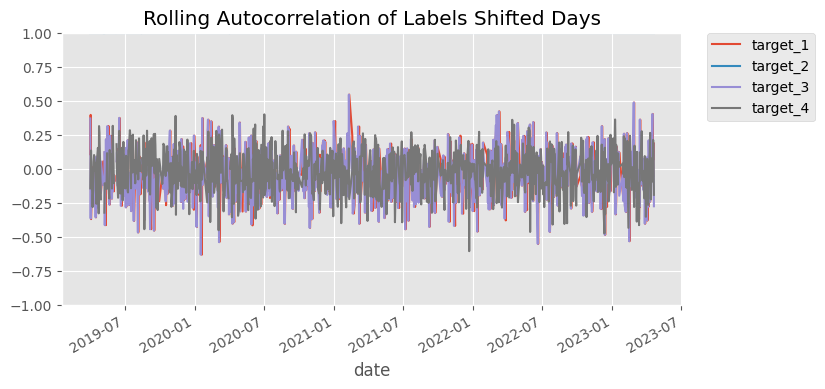

In [10]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220701].sort_index(level=['date', 'ts_code'])
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [11]:
features = [
            'alpha_kama', 'alpha_atr', 'alpha_atr14', 'alpha_kama2', 'alpha_kama3',
            'alpha_pb', 'alpha_ppo', 'alpha_fundamental', 'alpha_009', 'alpha_010',
            'alpha_056', 'alpha_069', 'alpha_075', 'alpha_083', 'alpha_101', 
            'alpha_103', 'alpha_122','alpha_149', 'alpha_030'
            ] + sector_columns

target_label = 'target'
print(all_factors.shape)

(95847, 76)


In [12]:
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_index(level=['date'])
print(all_factors.shape)
#all_factors.head()

(95371, 76)


In [13]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.75, 0.2, 0.05)

X_valid.tail()

alpha_kama  alpha_atr  alpha_atr14  alpha_kama2  \
date       ts_code                                                      
2023-02-09 688363.SH   -0.492324  -0.888094    -1.000000    -0.507780   
           688579.SH    0.752536   0.541182     0.554359     0.717282   
           688589.SH    0.296889  -0.165314    -0.130845     0.591931   
           688655.SH    0.528255   0.708298     0.725347     0.645181   
           688799.SH    0.225189   0.303898     0.061588     0.714711   

                      alpha_kama3  alpha_pb  alpha_ppo  alpha_fundamental  \
date       ts_code                                                          
2023-02-09 688363.SH    -1.000000 -1.000000   0.505816          -0.700120   
           688579.SH     0.768875 -0.135105  -0.059233          -0.947414   
           688589.SH    -0.179957 -0.396549   0.027665          -0.779880   
           688655.SH     0.672345  0.206658  -0.070646          -0.712472   
           688799.SH    -0.117441  0.488106   0.283300           0.060854   

                      alpha_009  alpha_010  ...  alpha_069  alpha_075  \
date       ts_code                          ...                         
2023-02-09 688363.SH  -1.000000  -1.000000  ...   0.538722  -0.403512   
           688579.SH   0.865452   0.910646  ...   0.694169   0.250394   
           688589.SH  -0.093839  -0.063265  ...   0.206628  -0.183246   
           688655.SH   0.877180   0.865195  ...  -0.414751  -0.128180   
           688799.SH   0.379544  -0.013536  ...  -0.153724   0.062992   

                      alpha_083  alpha_101  alpha_103  alpha_122  alpha_149  \
date       ts_code                                                            
2023-02-09 688363.SH   0.470372  -1.000000  -0.260628   0.431436   1.000000   
           688579.SH   0.157667  -1.000000   0.059960  -0.104269  -0.406155   
           688589.SH  -0.011321   0.881916  -1.000000   0.052636  -0.071502   
           688655.SH   0.549253  -1.000000  -1.000000  -0.133834   0.490487   
           688799.SH   1.000000  -1.000000  -0.820161   0.247209   0.077136   

                      alpha_030  sector_1  sector_0  
date       ts_code                                   
2023-02-09 688363.SH   0.871164      True     False  
           688579.SH  -0.145374     False      True  
           688589.SH   0.789923     False      True  
           688655.SH   0.974460     False      True  
           688799.SH   0.777278      True     False  

[5 rows x 21 columns]

In [14]:
X_test.head()

alpha_kama  alpha_atr  alpha_atr14  alpha_kama2  \
date       ts_code                                                      
2023-02-10 000411.SZ    0.794049   0.830068     0.711201     0.850022   
           000756.SZ    0.232208   0.373368    -0.050525     0.001728   
           000915.SZ    0.312500  -0.135534    -0.219404    -0.036819   
           002322.SZ    0.471645   0.823071     0.845530     0.748972   
           002362.SZ   -1.000000  -0.506533    -0.285849    -1.000000   

                      alpha_kama3  alpha_pb  alpha_ppo  alpha_fundamental  \
date       ts_code                                                          
2023-02-10 000411.SZ     0.738067  0.553206   0.410646           1.000000   
           000756.SZ     0.044934 -0.280081   1.000000          -0.418578   
           000915.SZ    -0.255004 -0.157896   0.530851          -0.366281   
           002322.SZ     0.803097  0.821125  -0.192500          -0.668225   
           002362.SZ    -0.104370 -0.512590  -1.000000          -0.781723   

                      alpha_009  alpha_010  ...  alpha_069  alpha_075  \
date       ts_code                          ...                         
2023-02-10 000411.SZ   0.954674   0.865335  ...  -0.104713   0.092373   
           000756.SZ   0.684011   1.000000  ...   1.000000  -0.658628   
           000915.SZ  -0.030464  -0.106724  ...   0.180970   0.294068   
           002322.SZ   0.956890   0.893167  ...  -0.415885   0.596610   
           002362.SZ  -0.020341  -0.020310  ...  -1.000000  -0.480364   

                      alpha_083  alpha_101  alpha_103  alpha_122  alpha_149  \
date       ts_code                                                            
2023-02-10 000411.SZ   0.210904  -1.000000   0.010111   0.402619  -0.120162   
           000756.SZ   0.359469  -1.000000   0.683960   0.997378  -0.163342   
           000915.SZ   0.427662  -1.000000   0.008818   0.466308   0.246367   
           002322.SZ   0.359469   0.836389   0.120613  -0.341319  -0.350578   
           002362.SZ  -1.000000  -1.000000  -0.940261  -1.000000  -0.403650   

                      alpha_030  sector_1  sector_0  
date       ts_code                                   
2023-02-10 000411.SZ   0.973451      True     False  
           000756.SZ   0.972400      True     False  
           000915.SZ  -0.054037      True     False  
           002322.SZ   0.648572     False      True  
           002362.SZ  -1.000000     False      True  

[5 rows x 21 columns]

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [15]:
n_days = 60
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 200,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [10, 20, 30]

### Pick Important Features by Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 3/3 [00:03<00:00,  1.33s/Model]


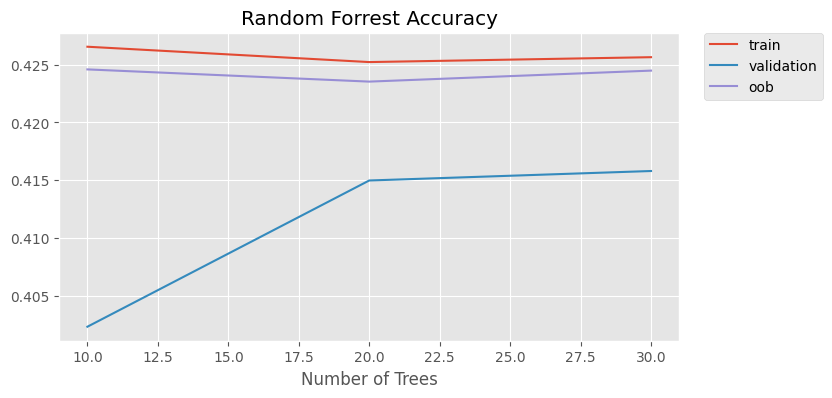

Features Ranked by Average Importance:

      Feature               Importance
 1. alpha_056         (0.18589081098187443)
 2. alpha_pb          (0.1802749482262996)
 3. alpha_atr         (0.14171572715581612)
 4. alpha_149         (0.1316897257553762)
 5. alpha_atr14       (0.10046987906128602)
 6. alpha_075         (0.0827504136664255)
 7. alpha_ppo         (0.05728294284708751)
 8. alpha_103         (0.04342678467342035)
 9. alpha_122         (0.01883462223140522)
10. sector_0          (0.012026874172655187)
11. alpha_kama2       (0.011779555687950354)
12. alpha_009         (0.009489867616202465)
13. sector_1          (0.008751060296354553)
14. alpha_fundamental (0.0081076399083121)
15. alpha_083         (0.0032751597779982523)
16. alpha_kama3       (0.0025497343032321023)
17. alpha_kama        (0.0016842536383041135)
18. alpha_010         (0.0)
19. alpha_069         (0.0)
20. alpha_101         (0.0)
21. alpha_030         (0.0)


In [17]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [76]:
n_days = 20
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    #'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [10, 30, 50]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 3/3 [00:07<00:00,  2.47s/Model]


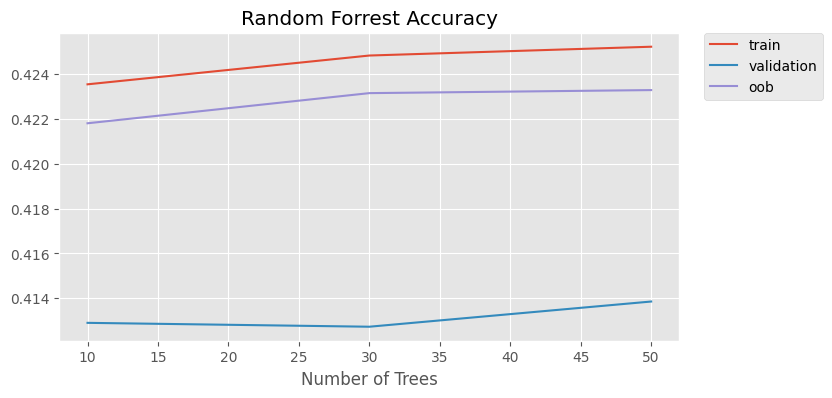

In [77]:
ph.plot(
    [n_trees_l]*5,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.41386010362694303
Precision score:  0.41386010362694303
Recall score:  0.41386010362694303
F1 score:  0.41386010362694303


In [79]:
factor_names = [ 
            'alpha_kama', 'alpha_atr', 'alpha_atr14', 'alpha_kama2', 'alpha_kama3','alpha_009',
            #'alpha_pb', 'alpha_ppo', 'alpha_fundamental', 'alpha_010',
            #'alpha_056', 'alpha_069', 'alpha_075', 'alpha_083', 'alpha_101', 
            #'alpha_103', 'alpha_122','alpha_149', 'alpha_030'
            ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')

### Evalueate alpha factor

In [80]:
import alphalens as al
from scipy.stats import zscore

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    # only for long factor evaluate
    #for name in (factors + [alpha_score_label]):
    #    factors_with_alpha[name] = np.where(factors_with_alpha[name]>0, factors_with_alpha[name], 0.)
        
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing, holding_time=2)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

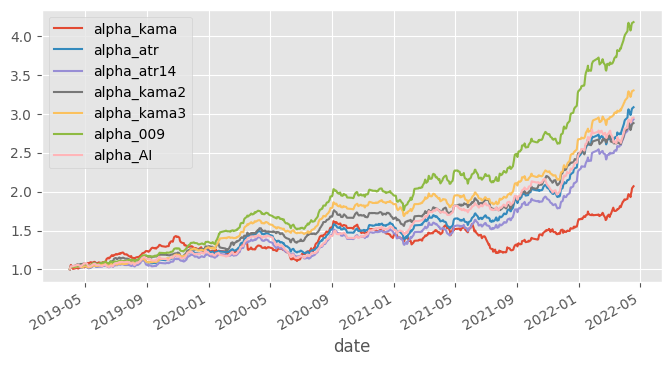

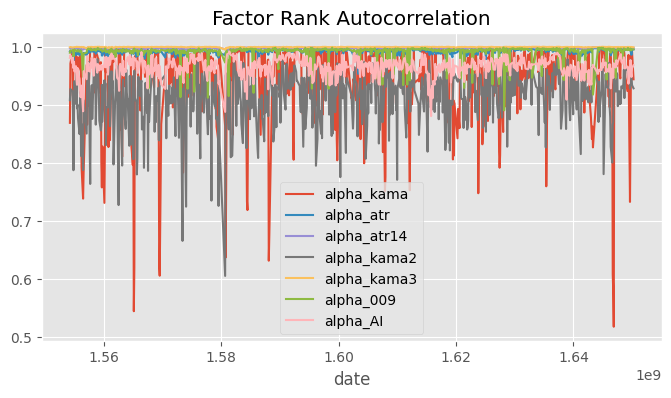

In [81]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

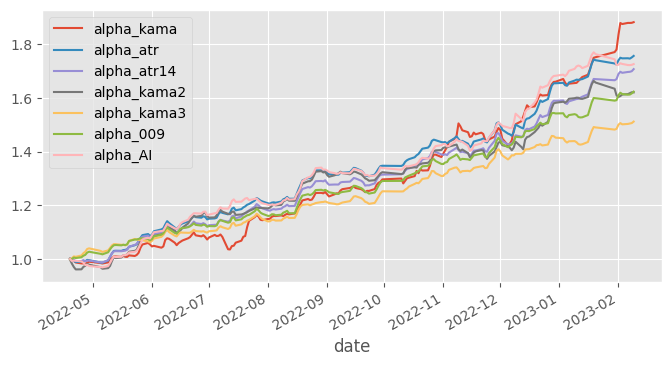

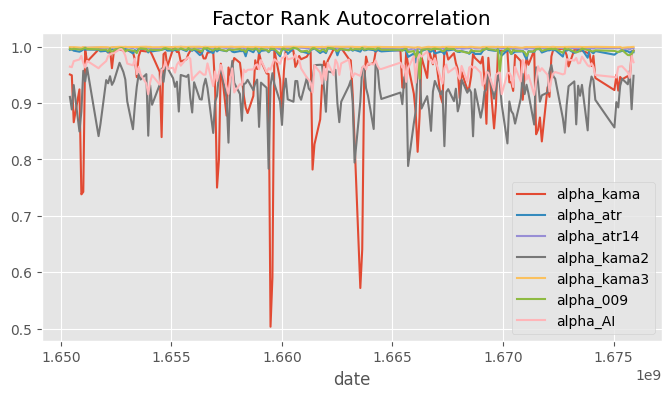

In [82]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [83]:
n_days = 20
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 50

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [84]:
print(train_score)
print(valid_score, oob_score)

[0.42400507085615974]
[0.42236614853195165] [0.42212679001420617]


### View Train Set Results

Cleaning Data...

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

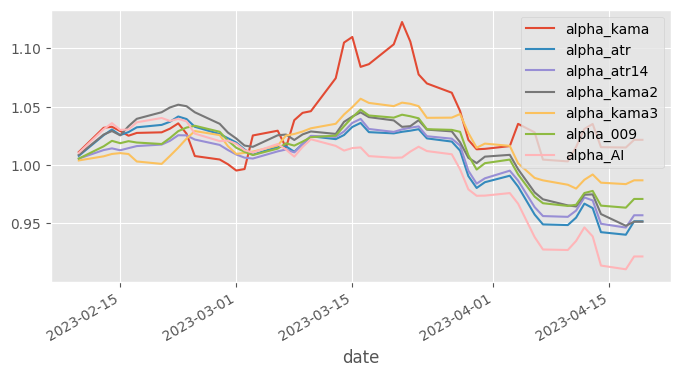

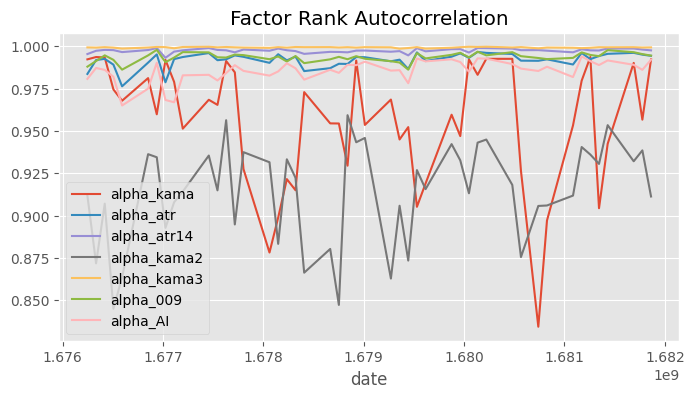

In [85]:
#show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

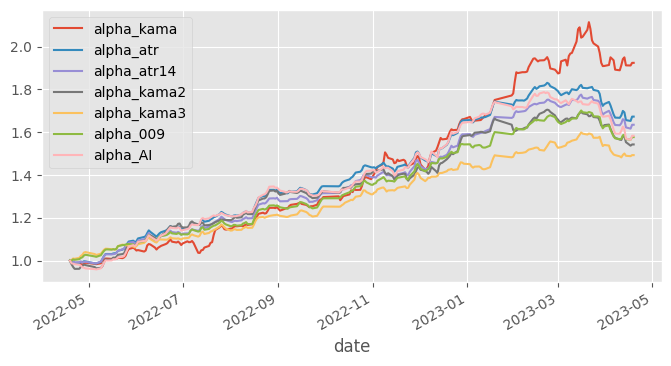

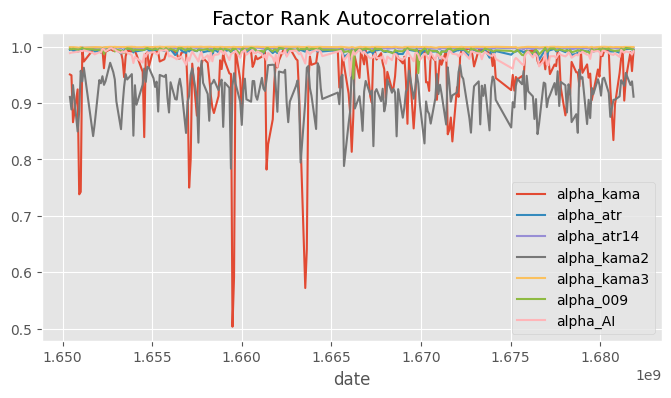

In [86]:
factor_names = [
            'alpha_kama', 'alpha_atr', 'alpha_atr14', 'alpha_kama2', 'alpha_kama3','alpha_009',
            #'alpha_pb', 'alpha_ppo', 'alpha_fundamental', 'alpha_010',
            #'alpha_056', 'alpha_069', 'alpha_075', 'alpha_083', 'alpha_101', 
            #'alpha_103', 'alpha_122','alpha_149', 'alpha_030'   
           ]
#tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([X_valid, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [87]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
#     factors_with_alpha = factors_with_alpha.reset_index()
#     factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
#     factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    return factors_with_alpha

sample_all = universe.reset_index()
sample_all.set_index(['date','ts_code']).sort_values(by=['date'])
save_factors = save_AI_factors(sample_all, clf_nov)
save_factors = save_factors.reset_index().set_index(['date'])
save_factors = universe.merge(save_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[ 0.0031237   0.00883993 -0.05503135 ... -0.041264    0.01790003
 -0.03286735] 95847


<AxesSubplot:>

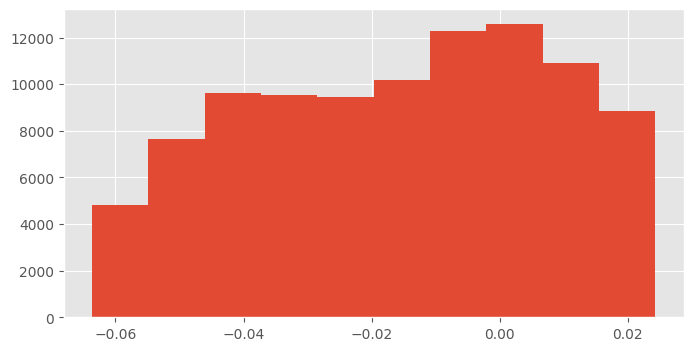

In [88]:
save_factors['alpha_AI'].hist()

In [90]:
#save_factors['alpha_pb'] = -save_factors['pb']
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
         'alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI', 
        ]
save_factors[field].to_csv('AI_data/factors_AI_119.csv')

In [91]:
save_factors[field]

,ts_code,trade_date,name,industry,close,log-ret,alpha_atr,alpha_kama,alpha_009,alpha_AI
0,000411.SZ,20190402,英特集团,医药商业,11.62218,0.034522,0.700408,0.905303,0.835623,0.003124
1,000756.SZ,20190402,新华制药,化学制药,7.50785,-0.012579,0.825542,-0.381973,0.948680,0.008840
2,000915.SZ,20190402,华特达因,化学制药,23.11107,0.008987,-0.137051,-0.599272,-0.018589,-0.055031
3,002322.SZ,20190402,理工能科,软件服务,13.86588,0.064248,0.145920,-0.483201,0.560346,-0.040818
4,002362.SZ,20190402,汉王科技,软件服务,18.26000,0.008801,-0.007877,-0.445442,0.398111,-0.024082
...,...,...,...,...,...,...,...,...,...,...
95842,688363.SH,20230427,华熙生物,医疗保健,99.45000,0.028042,-0.347717,-0.093978,-0.633329,-0.036075
95843,688579.SH,20230427,山大地纬,软件服务,15.45000,0.042306,0.162151,-0.000219,0.757856,-0.032227
95844,688589.SH,20230427,力合微,半导体,43.59000,-0.013897,-0.199810,-0.034529,-0.100953,-0.041264
95845,688655.SH,20230427,迅捷兴,元器件,12.05000,-0.002487,0.761269,0.026345,0.918403,0.017900


### Save RandomForest Model

In [92]:
import joblib

joblib.dump(clf_nov, 'AI_data/clf_119.pkl')


['AI_data/clf_119.pkl']

Load model example

In [ ]:
clf_load = joblib.load('clf_20230401.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
print(alpha_score, len(alpha_score))